In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Data Prerpocessing

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from joblib import load, dump
import numpy as np
import time
from collections import Counter

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA 
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from boruta import BorutaPy 

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

dir = '/content/drive/My Drive/Fashion MNIST/'

In [0]:
train_df = pd.read_csv(dir + 'fashion-mnist_train.csv')
test_df = pd.read_csv(dir + 'fashion-mnist_test.csv')
features_list = train_df.columns.values[1:]

In [46]:
#Get 2 samples from each class
training_class_count = Counter(train_df.iloc[:,0].values)
test_class_count = Counter(test_df.iloc[:,0].values)

print("Training Class count :")
print(training_class_count)
print("Test Class count :")
print(test_class_count)

Training Class count :
Counter({2: 6000, 9: 6000, 6: 6000, 0: 6000, 3: 6000, 4: 6000, 5: 6000, 8: 6000, 7: 6000, 1: 6000})
Test Class count :
Counter({0: 1000, 1: 1000, 2: 1000, 3: 1000, 8: 1000, 6: 1000, 5: 1000, 4: 1000, 7: 1000, 9: 1000})


#Boruta Implementation

In [0]:
#Using Bourta algorithm to perform wrapper feature selection
rf = RandomForestClassifier(n_estimators=10, criterion='entropy', n_jobs=-1, random_state=42)

feature_selector = BorutaPy(rf, n_estimators='auto', random_state=42, verbose=1, max_iter=15)
feature_selector.fit(x_train_scaled, y_train)

Iteration: 1 / 15
Iteration: 2 / 15
Iteration: 3 / 15
Iteration: 4 / 15
Iteration: 5 / 15
Iteration: 6 / 15
Iteration: 7 / 15
Iteration: 8 / 15
Iteration: 9 / 15
Iteration: 10 / 15
Iteration: 11 / 15
Iteration: 12 / 15
Iteration: 13 / 15
Iteration: 14 / 15


BorutaPy finished running.

Iteration: 	15 / 15
Confirmed: 	630
Tentative: 	11
Rejected: 	130


BorutaPy(alpha=0.05,
         estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                          criterion='entropy', max_depth=None,
                                          max_features='auto',
                                          max_leaf_nodes=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=361, n_jobs=-1,
                                          oob_score=False,
                                          random_state=RandomState(MT19937) at 0x7F353E2B7360,
                                          verbose=0, warm_start=False),
         max_iter=15, n_estimators='auto', perc=100,
         rando

In [0]:
feature_selector =  load('/content/drive/My Drive/Fashion MNIST/feature_selector_new.joblib')

In [11]:
selected_features = [features_list[idx] for idx, i in enumerate(feature_selector.support_) if i == True]
len(selected_features)

630

In [0]:
features = pd.DataFrame(columns=["Boruta Features"])
features["Boruta Features"] = selected_features
features.to_csv('/content/drive/My Drive/Fashion MNIST/boruta_features_new.csv', index=False)

In [0]:
features_df = pd.read_csv('/content/drive/My Drive/Fashion MNIST/boruta_features_new.csv')
new_train_df = train_df[["label"] + list(features_df["Boruta Features"])]
new_test_df = test_df[["label"] + list(features_df["Boruta Features"])]

In [0]:
x_train = new_train_df.iloc[:,1:]
y_train = new_train_df.iloc[:,0].values
x_test = new_test_df.iloc[:,1:]
y_test = new_test_df.iloc[:,0].values
classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", 
           "Shirt", "Sneaker", "Bag", "Ankle boot"]

#Z-Score normalization:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

x_train_scaled_full = scaler.fit_transform(train_df.iloc[:,1:].values)
x_test_scaled_full = scaler.fit_transform(test_df.iloc[:,1:].values)

#Create code for the demo

In [0]:
#Create  sample for the demo
#Code is simply used to extract 10 test samples for each class from the test set
demo_test_df = pd.DataFrame(columns=new_test_df.columns.values)

for idx, each_class in enumerate(classes):
  #Pick the first two samples from each class

  test_indices = test_df.index[test_df['label'] == idx][:10]
  x_sample = x_test_scaled[test_indices]
  y_sample = y_test[test_indices]

  temp_df = pd.DataFrame(np.column_stack([y_sample, x_sample]),
                         columns= demo_test_df.columns.values)
  demo_test_df = pd.concat([demo_test_df, temp_df], axis=0)


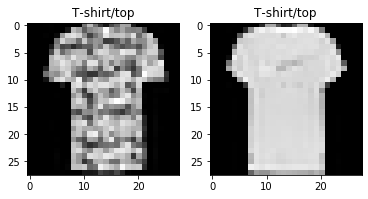

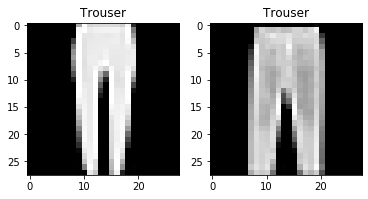

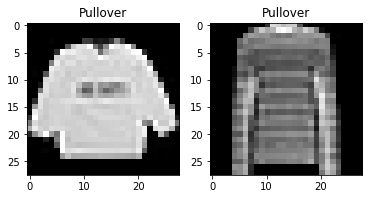

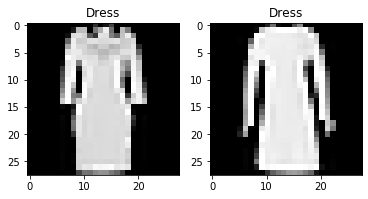

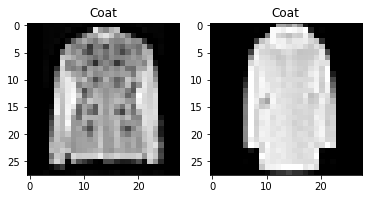

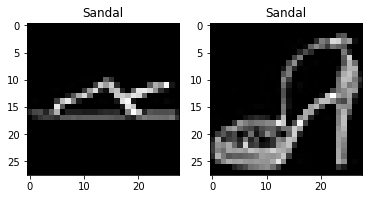

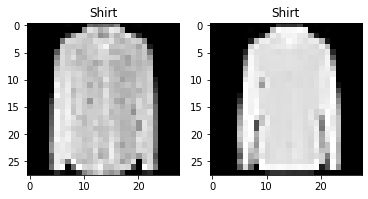

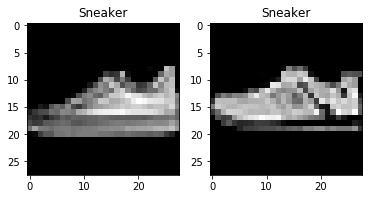

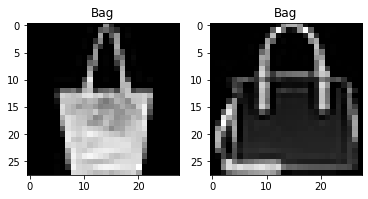

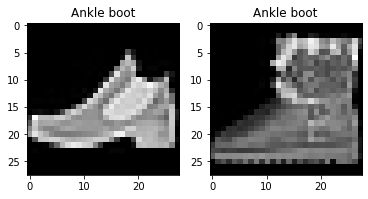

In [16]:
#Displaying the differences in samples of a class

for idx, each_class in enumerate(classes):
  #Pick the first two samples from each class
  temp_train_df = train_df.loc[train_df['label'] == idx][:2]

  figure,ax = plt.subplots(1, 2)
  
  sample_1 = temp_train_df.iloc[0]
  image_1 = np.array(sample_1[1:]).reshape((28,28))
  ax[0].set_title(classes[idx])
  ax[0].imshow(image_1, cmap="gray")
  

  sample_2 = temp_train_df.iloc[1]
  image_2 = np.array(sample_2[1:]).reshape((28,28))
  ax[1].set_title(classes[idx])
  ax[1].imshow(image_2, cmap="gray")


#Correlation matrix evaluation

In [0]:
#Get all features that are positively correlated with the target feature
correlation_df = new_train_df.corr()

target = correlation_df['label']
most_cor_features = target[target > 0.0]

In [42]:
#Printing the list of positively correlated features.
#Using this set of features did not improve accuracy and hence this
#method of feature selection was not used further on 
list(most_cor_features.keys())

['label',
 'pixel137',
 'pixel164',
 'pixel165',
 'pixel166',
 'pixel192',
 'pixel193',
 'pixel194',
 'pixel195',
 'pixel218',
 'pixel219',
 'pixel220',
 'pixel221',
 'pixel222',
 'pixel223',
 'pixel245',
 'pixel246',
 'pixel247',
 'pixel248',
 'pixel249',
 'pixel250',
 'pixel251',
 'pixel272',
 'pixel273',
 'pixel274',
 'pixel275',
 'pixel276',
 'pixel277',
 'pixel278',
 'pixel279',
 'pixel284',
 'pixel299',
 'pixel300',
 'pixel301',
 'pixel302',
 'pixel303',
 'pixel304',
 'pixel305',
 'pixel306',
 'pixel307',
 'pixel312',
 'pixel313',
 'pixel323',
 'pixel326',
 'pixel327',
 'pixel328',
 'pixel329',
 'pixel330',
 'pixel331',
 'pixel332',
 'pixel333',
 'pixel334',
 'pixel335',
 'pixel340',
 'pixel341',
 'pixel342',
 'pixel351',
 'pixel354',
 'pixel355',
 'pixel356',
 'pixel357',
 'pixel358',
 'pixel359',
 'pixel360',
 'pixel361',
 'pixel362',
 'pixel363',
 'pixel366',
 'pixel369',
 'pixel370',
 'pixel371',
 'pixel372',
 'pixel378',
 'pixel379',
 'pixel380',
 'pixel381',
 'pixel382',
 '

#Principal Component Anaysis

In [0]:
#PCA experiments
x_train_pca = PCA(random_state=42).fit(x_train_scaled_full)
x_test_pca = PCA(random_state=42).fit(x_test_scaled_full)

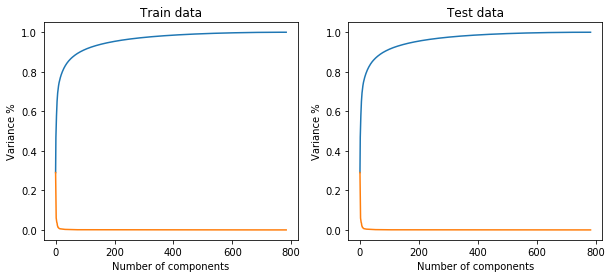

In [54]:
#PCA analysis
#Despite trying different levels of variance I could not reduce the number
#of features to an amount that would help improve the prediction accuracy score

figure,ax = plt.subplots(1, 2, figsize=(10,4))

cumulative_variances_train = np.cumsum(x_train_pca.explained_variance_ratio_)
ax[0].plot(cumulative_variances_train)
variance_adding_features_train = x_train_pca.explained_variance_ratio_
ax[0].plot(variance_adding_features_train)
ax[0].set_ylabel('Variance %')
ax[0].set_xlabel('Number of components')
ax[0].set_title("Train data")

cumulative_variances_test = np.cumsum(x_test_pca.explained_variance_ratio_)
ax[1].plot(cumulative_variances_test)
variance_adding_features_test = x_test_pca.explained_variance_ratio_
ax[1].plot(variance_adding_features_test)
ax[1].set_ylabel('Variance %')
ax[1].set_xlabel('Number of components')
ax[1].set_title("Test data")

plt.show()

#Mutual Information for feaure selection

In [0]:
#MI did not provide good results in terms of filtering features 
#The maximum features it could reduce was 1 to 3.
mi = mutual_info_classif(x_train_scaled_full, y_train, n_neighbors=3, random_state=42)

In [0]:
selected_features = [features_list[idx] for idx, i in enumerate(mi) if i > 0.000]
len(selected_features)

783